In [15]:
import pyemma
import numpy as np

In [16]:
dtrajs = list(np.load('100.npy'))

In [17]:
len(dtrajs)

5019

In [108]:
bmsm = pyemma.msm.bayesian_markov_model(dtrajs, 100)

HBox(children=(HBox(children=(Label(value='Sampling MSMs'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [5]:
bmsm.nstates

99

In [6]:
timescales = pyemma.msm.timescales_msm(dtrajs, errors='bayes', n_jobs=6)

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=16), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [8]:
timescales.save('apo_bmsm_timescales_')

In [12]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

In [13]:
sns.set_context('paper')
sns.set(font='Arial')
sns.set_style('ticks')

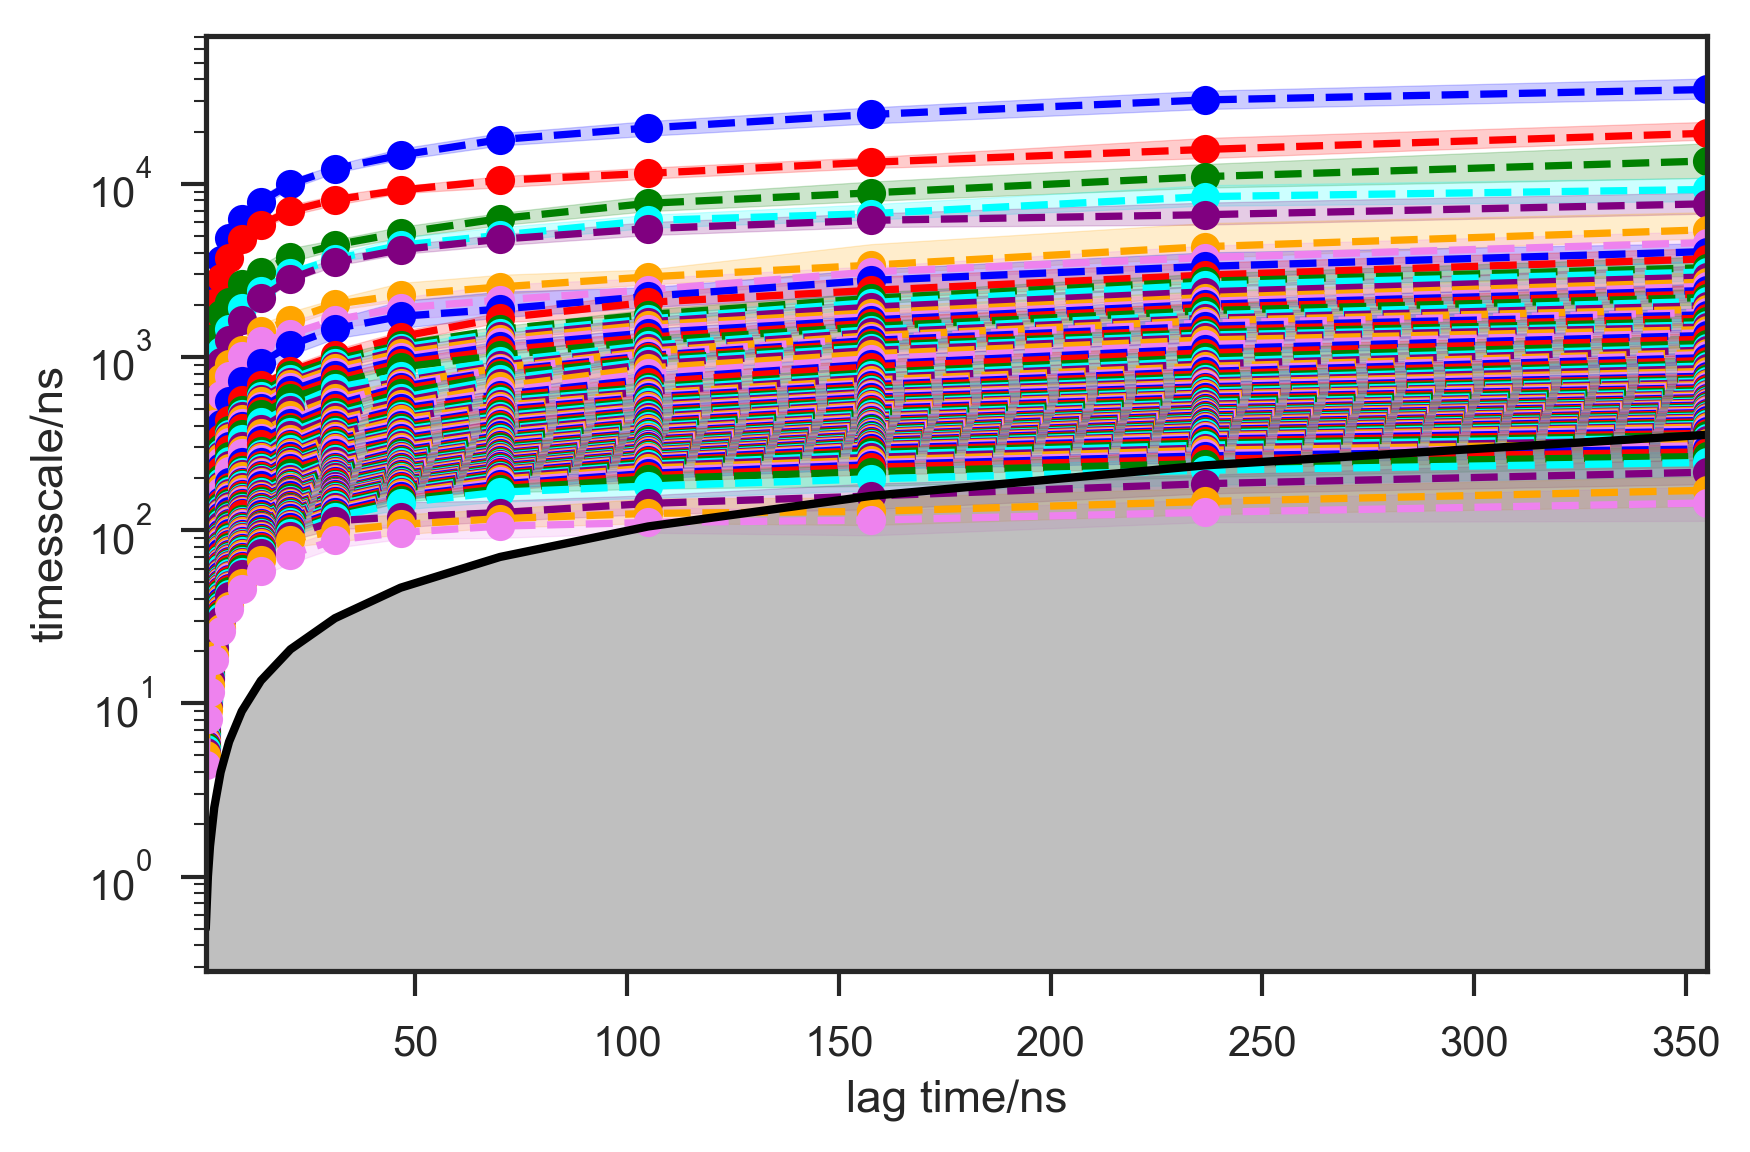

In [11]:
plt.figure(dpi=300)
pyemma.plots.plot_implied_timescales(timescales, dt=0.5, units='ns', show_mle=False, show_mean=True)
plt.xlabel('lag time/ns')
plt.ylabel('timesscale/ns')
plt.tight_layout()
#plt.savefig('apo_BMSM_timescales_mean.pdf')
plt.show()

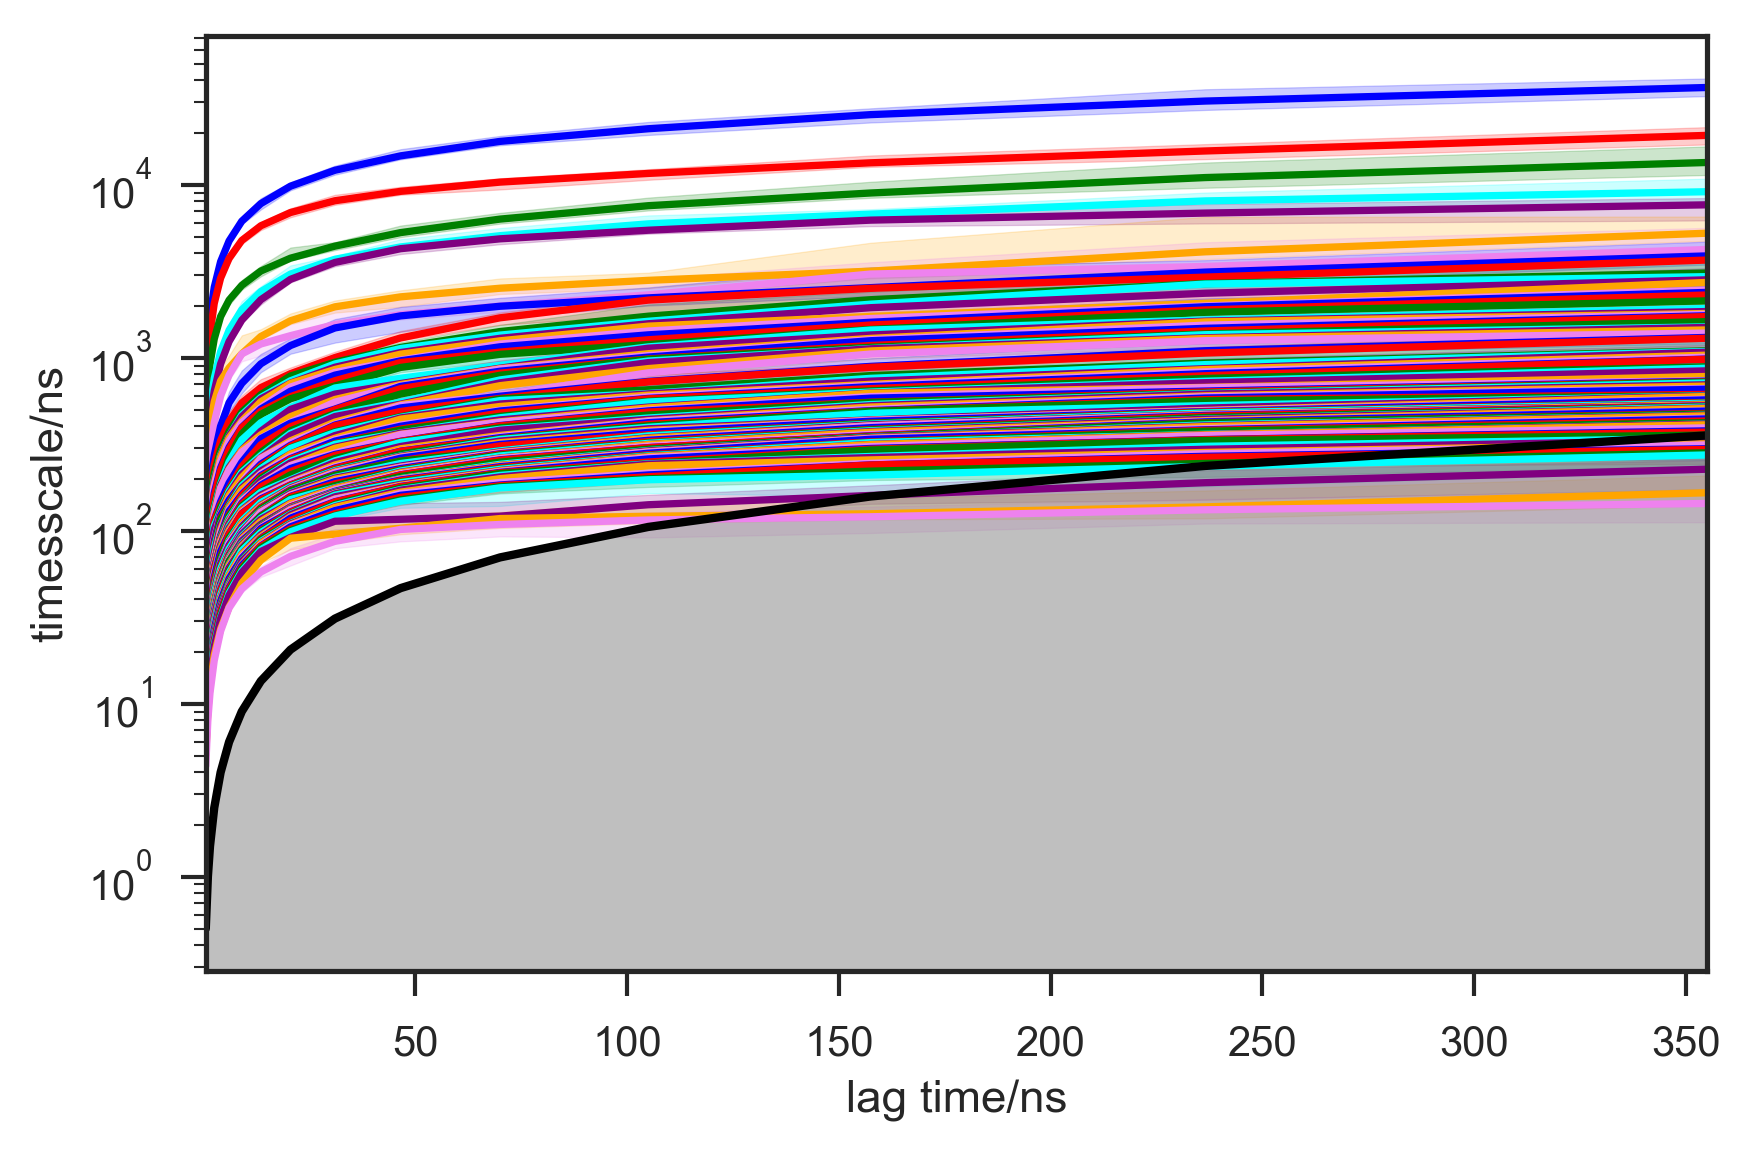

In [26]:
plt.figure(dpi=300)
pyemma.plots.plot_implied_timescales(timescales, dt=0.5, units='ns', show_mle=True, show_mean=False)
plt.xlabel('lag time/ns')
plt.ylabel('timesscale/ns')
plt.tight_layout()
plt.savefig('apo_BMSM_timescales_mle.pdf')
plt.show()

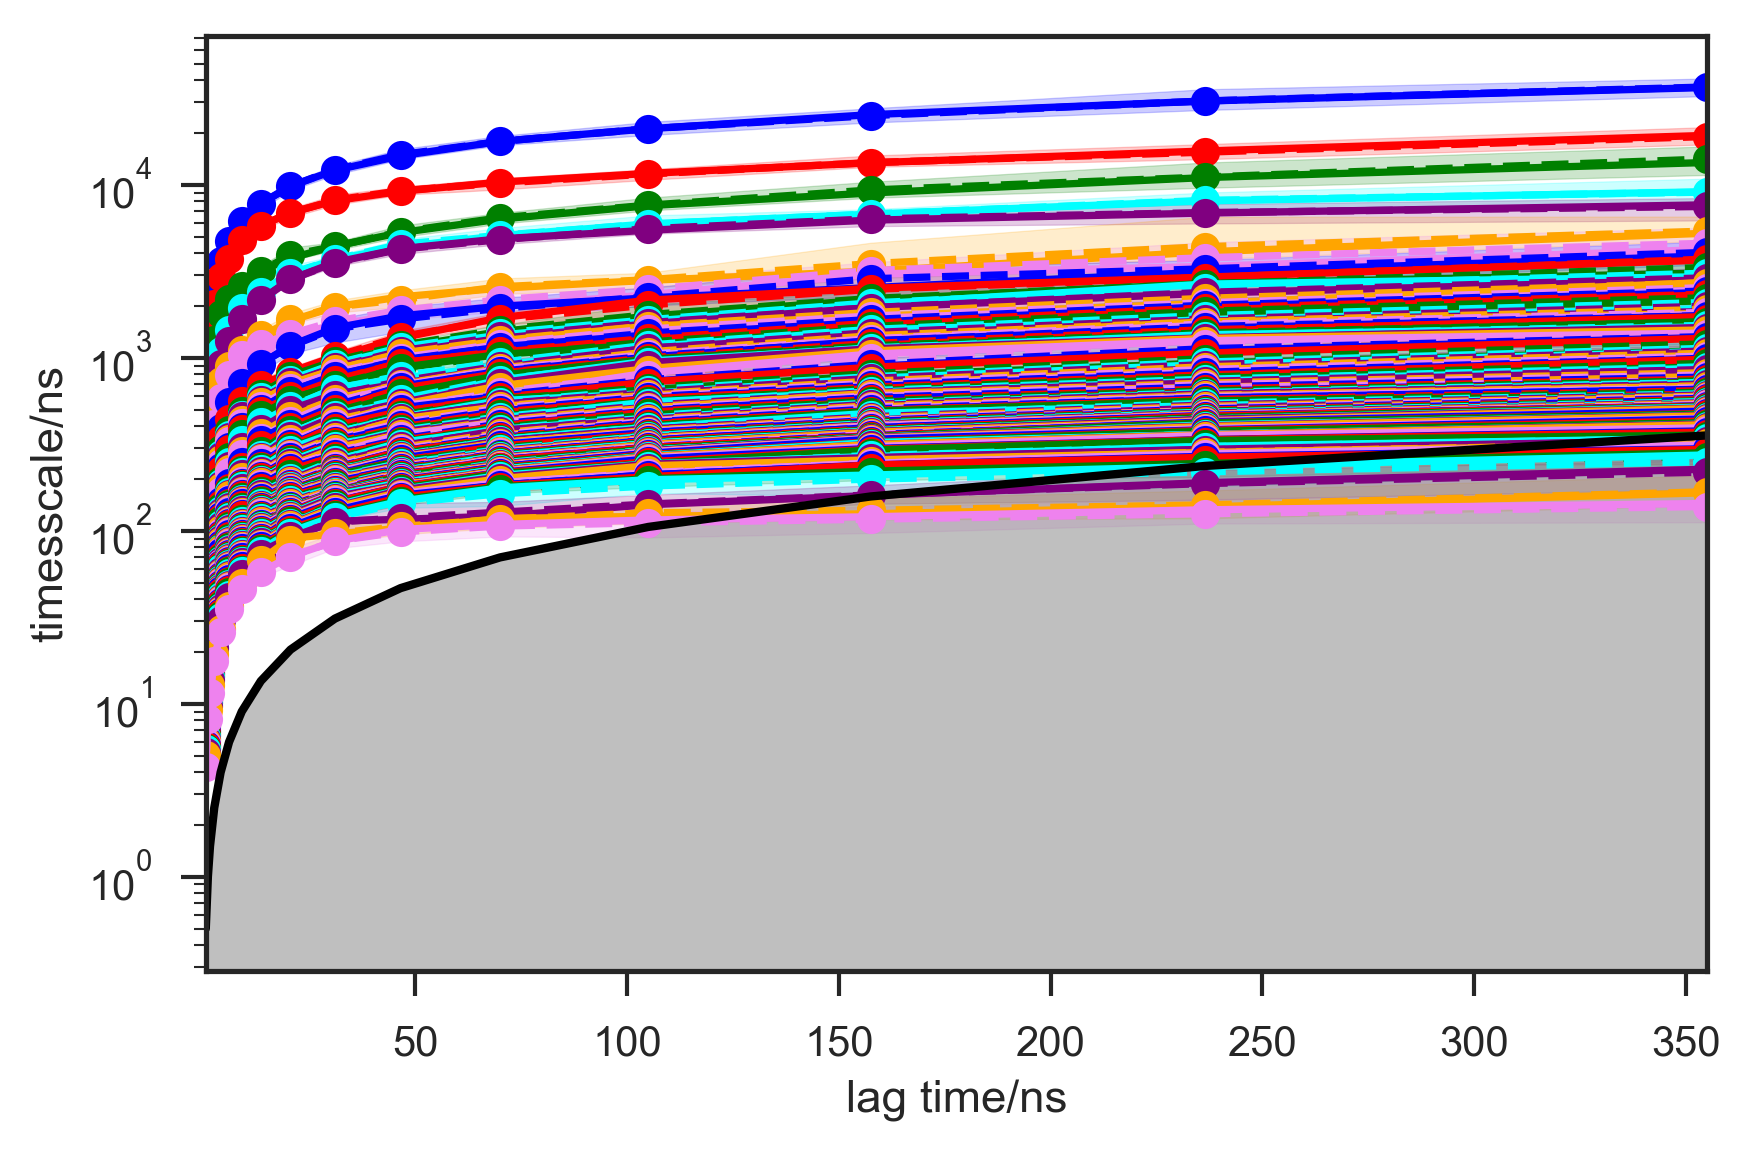

In [27]:
plt.figure(dpi=300)
pyemma.plots.plot_implied_timescales(timescales, dt=0.5, units='ns', show_mle=True, show_mean=True)
plt.xlabel('lag time/ns')
plt.ylabel('timesscale/ns')
plt.tight_layout()
plt.savefig('apo_BMSM_timescales_mean_mle.pdf')
plt.show()

In [24]:
pwd

'/Users/rafalpwiewiora/repos/MSM/11707_11709_SET8_apo_FINAL/PAPER_FIGURES/bayesian_models/apo'

In [30]:
# we're going with mle+mean, but only show top 23 timescales (because 24 macrostates)

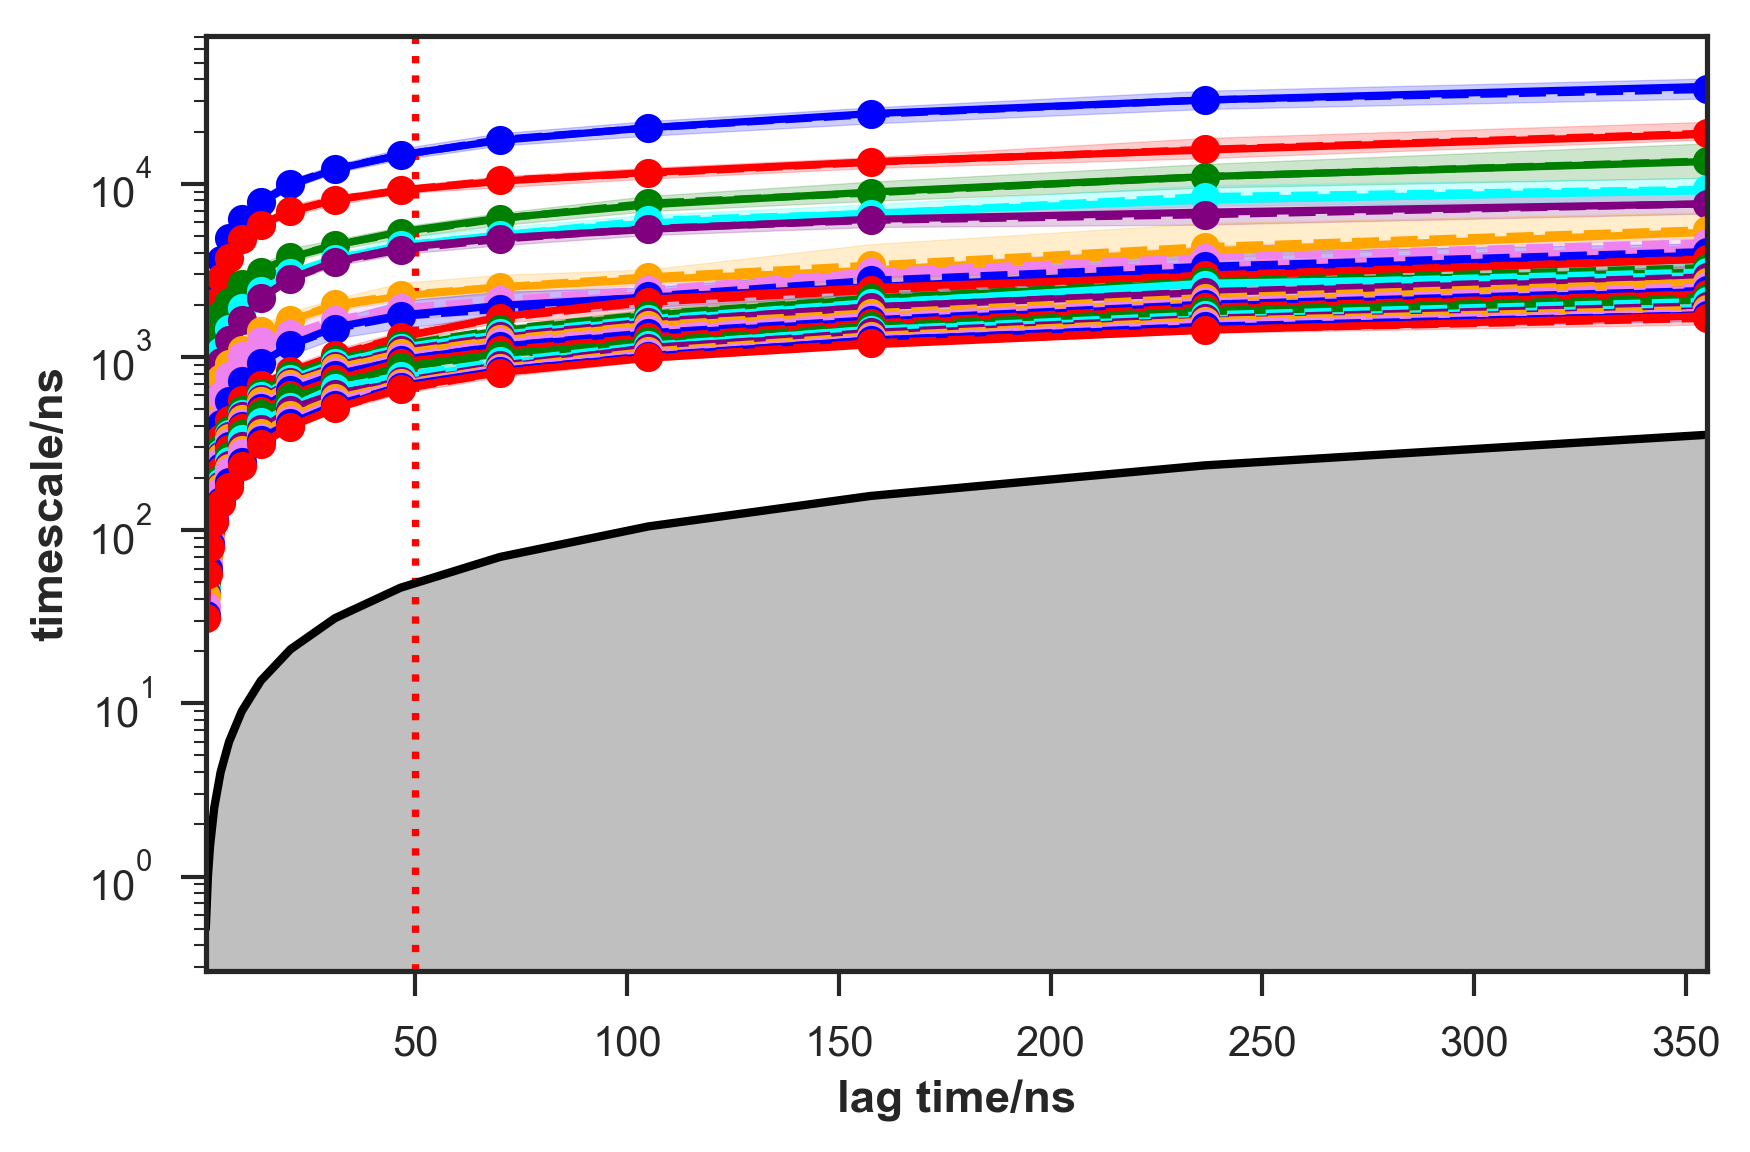

In [14]:
plt.rcParams['axes.labelweight'] = 'bold'
plt.figure(dpi=300)
ax = pyemma.plots.plot_implied_timescales(timescales, dt=0.5, units='ns', show_mle=True, show_mean=True, nits=23)
plt.xlabel('lag time/ns')
plt.ylabel('timescale/ns')
ylim = ax.get_ylim()
plt.vlines(50, ylim[0], ylim[1], colors="red", linestyles="dotted")
ax.set_ylim(ylim)
plt.tight_layout()
plt.savefig('apo_BMSM_timescales_mean_mle_23timescales.pdf')
plt.show()

In [ ]:
# CK-test

In [32]:
memb_25 = np.load('/Users/rafalpwiewiora/repos/MSM/11707_11709_SET8_apo_FINAL/dih_full_dset/hmms/results/25/metastable_memberships.npy')
memb_25 = np.concatenate([memb_25[:68], memb_25[69:]])

In [33]:
cktest = bmsm.cktest(24, memberships=memb_25, err_est=True, n_jobs=8)

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=9), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

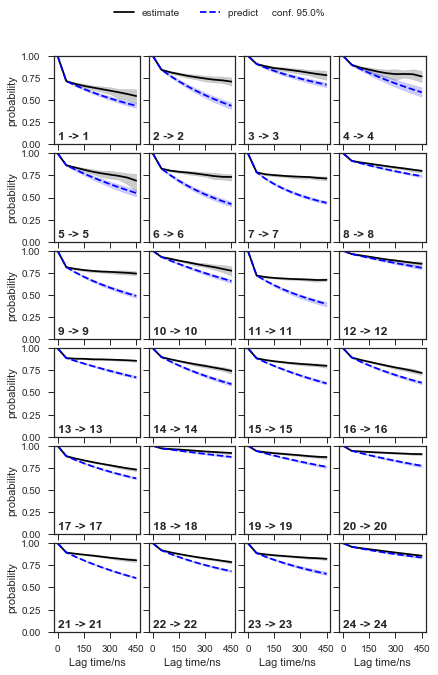

In [106]:
fig, axes = pyemma.plots.plot_cktest(cktest, diag=True, units='ns', dt=0.5)
axes[5,0].set_xlabel('Lag time/ns')
axes[5,1].set_xlabel('Lag time/ns')
axes[5,2].set_xlabel('Lag time/ns')
axes[5,3].set_xlabel('Lag time/ns')
axes[5,0].set_xticks([0,150,300,450])
plt.savefig('cktest_apo_diag.pdf')
plt.show()

In [59]:
pwd

'/Users/rafalpwiewiora/repos/MSM/11707_11709_SET8_apo_FINAL/PAPER_FIGURES/bayesian_models/apo'

In [107]:
# run with mlags None too

In [ ]:
# have to modify code here - estimator.active_set vs model.active_set bug

In [18]:
# This file is part of PyEMMA.
#
# Copyright (c) 2015, 2014 Computational Molecular Biology Group, Freie Universitaet Berlin (GER)
#
# PyEMMA is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

from __future__ import absolute_import
from six.moves import range

import math
import numpy as np

from pyemma._base.serialization.serialization import SerializableMixIn, Modifications
from pyemma._base.estimator import Estimator, estimate_param_scan, param_grid
from pyemma._base.model import SampledModel
from pyemma._base.progress import ProgressReporterMixin
from pyemma.util.statistics import confidence_interval
from pyemma.util import types

__author__ = 'noe'


class LaggedModelValidator(Estimator, ProgressReporterMixin, SerializableMixIn):
    r""" Validates a model estimated at lag time tau by testing its predictions
    for longer lag times

    Parameters
    ----------
    test_model : Model
        Model to be tested

    test_estimator : Estimator
        Parametrized Estimator that has produced the model

    mlags : int or int-array, default=10
        multiples of lag times for testing the Model, e.g. range(10).
        A single int will trigger a range, i.e. mlags=10 maps to
        mlags=range(10). The setting None will choose mlags automatically
        according to the longest available trajectory
        Note that you need to be able to do a model prediction for each
        of these lag time multiples, e.g. the value 0 only make sense
        if _predict_observables(0) will work.

    conf : float, default = 0.95
        confidence interval for errors

    err_est : bool, default=False
        if the Estimator is capable of error calculation, will compute
        errors for each tau estimate. This option can be computationally
        expensive.

    n_jobs : int, default=1
        how many jobs to use during calculation

    show_progress : bool, default=True
        Show progressbars for calculation?

    """
    __serialize_version = 1
    __serialize_fields = ('_lags',
                          '_pred', '_pred_L', '_pred_R',
                          '_est', '_est_L', '_est_R')

    def __init__(self, test_model, test_estimator, mlags=None, conf=0.95, err_est=False,
                 n_jobs=1, show_progress=True):

        # set model and estimator
        # copy the test model, since the estimation of cktest modifies the model.
        from copy import deepcopy
        self.test_model = deepcopy(test_model)
        self.test_estimator = test_estimator

        # set mlags
        try:
            maxlength = np.max([len(dtraj) for dtraj in test_estimator.discrete_trajectories_full])
        except AttributeError:
            maxlength = np.max(test_estimator.trajectory_lengths())
        maxmlag = int(math.floor(maxlength / test_estimator.lag))
        if mlags is None:
            mlags = maxmlag
        if types.is_int(mlags):
            mlags = np.arange(mlags)
        mlags = types.ensure_ndarray(mlags, ndim=1, kind='i')
        if np.any(mlags > maxmlag):
            mlags = mlags[np.where(mlags <= maxmlag)]
            self.logger.warning('Changed mlags as some mlags exceeded maximum trajectory length.')
        if np.any(mlags < 0):
            mlags = mlags[np.where(mlags >= 0)]
            self.logger.warning('Changed mlags as some mlags were negative.')
        self.mlags = mlags

        # set conf and error handling
        self.conf = conf
        self.has_errors = issubclass(self.test_model.__class__, SampledModel)
        if self.has_errors:
            self.test_model.set_model_params(conf=conf)
        self.err_est = err_est
        if err_est and not self.has_errors:
            raise ValueError('Requested errors on the estimated models, '
                             'but the model is not able to calculate errors at all')
        self.n_jobs = n_jobs
        self.show_progress = show_progress

    def _estimate(self, data):
        # lag times
        self._lags = np.array(self.mlags) * self.test_estimator.lag
        pargrid = list(param_grid({'lag': self._lags}))
        # do we have zero lag? this must be treated separately
        include0 = self.mlags[0] == 0
        if include0:
            pargrid = pargrid[1:]

        self._pred = []
        self._pred_L = []
        self._pred_R = []

        self._est = []
        self._est_L = []
        self._est_R = []

        # clone estimators and run estimates

        if self.show_progress:
            if isinstance(self.test_estimator, SampledModel):
                self.test_estimator.show_progress = False
            progress_reporter = self
        else:
            progress_reporter = None

        estimated_models, estimators = \
            estimate_param_scan(self.test_estimator, data, pargrid, return_estimators=True, failfast=False,
                                progress_reporter=progress_reporter, n_jobs=self.n_jobs)
        if include0:
            estimated_models = [None] + estimated_models
            estimators = [None] + estimators

        for i in range(len(self.mlags)):
            mlag = self.mlags[i]

            # make a prediction using the current model
            self._pred.append(self._compute_observables(self.test_model, self.test_estimator, mlag))
            # compute prediction errors if we can
            if self.has_errors:
                l, r = self._compute_observables_conf(self.test_model, self.test_estimator, mlag)
                self._pred_L.append(l)
                self._pred_R.append(r)

            # do an estimate at this lagtime
            model = estimated_models[i]
            estimator = estimators[i]
            self._est.append(self._compute_observables(model, estimator))
            if self.has_errors and self.err_est:
                l, r = self._compute_observables_conf(model, estimator)
                self._est_L.append(l)
                self._est_R.append(r)

        # build arrays
        self._est = np.array(self._est)
        self._pred = np.array(self._pred)
        if self.has_errors:
            self._pred_L = np.array(self._pred_L)
            self._pred_R = np.array(self._pred_R)
        else:
            self._pred_L = None
            self._pred_R = None
        if self.has_errors and self.err_est:
            self._est_L = np.array(self._est_L)
            self._est_R = np.array(self._est_R)
        else:
            self._est_L = None
            self._est_R = None

        return self

    @property
    def lagtimes(self):
        return self._lags

    @property
    def estimates(self):
        """ Returns estimates at different lagtimes

        Returns
        -------
        Y : ndarray(T, n)
            each row contains the n observables computed at one of the T lag t
            imes.

        """
        return self._est

    @property
    def estimates_conf(self):
        """ Returns the confidence intervals of the estimates at different
        lagtimes (if available).

        If not available, returns None.

        Returns
        -------
        L : ndarray(T, n)
            each row contains the lower confidence bound of n observables
            computed at one of the T lag times.

        R : ndarray(T, n)
            each row contains the upper confidence bound of n observables
            computed at one of the T lag times.

        """
        return self._est_L, self._est_R

    @property
    def predictions(self):
        """ Returns tested model predictions at different lagtimes

        Returns
        -------
        Y : ndarray(T, n)
            each row contains the n observables predicted at one of the T lag
            times by the tested model.

        """
        return self._pred

    @property
    def predictions_conf(self):
        """ Returns the confidence intervals of the estimates at different
        lagtimes (if available)

        If not available, returns None.

        Returns
        -------
        L : ndarray(T, n)
            each row contains the lower confidence bound of n observables
            computed at one of the T lag times.

        R : ndarray(T, n)
            each row contains the upper confidence bound of n observables
            computed at one of the T lag times.

        """
        return self._pred_L, self._pred_R

    # USER functions
    def _compute_observables(self, model, estimator, mlag=1):
        """Compute observables for given model

        Parameters
        ----------
        model : Model
            model to compute observable for.

        estimator : Estimator
            estimator that has produced the model.

        mlag : int, default=1
            if 1, just compute the observable for given model. If not 1, use
            model to predict result at multiple of given model lagtime. Note
            that mlag=0 (no propagation) can occur and should be handled.

        Returns
        -------
        Y : ndarray
            array with results

        """
        raise NotImplementedError('_compute_observables is not implemented. Must override it in subclass!')

    def _compute_observables_conf(self, model, estimator, mlag=1):
        """Compute confidence interval for observables for given model

        Parameters
        ----------
        model : Model
            model to compute observable for. model can be None if mlag=0.
            This scenario must be handled.

        estimator : Estimator
            estimator that has produced the model. estimator can be None if
            mlag=0. This scenario must be handled.

        mlag : int, default=1
            if 1, just compute the observable for given model. If not 1, use
            model to predict result at multiple of given model lagtime. Note
            that mlag=0 (no propagation) can occur and should be handled.

        Returns
        -------
        L : ndarray
            array with lower confidence bounds
        R : ndarray
            array with upper confidence bounds

        """
        raise NotImplementedError('_compute_observables is not implemented. Must override it in subclass!')

    def __setstate__(self, state):
        try:
            input_version = state['class_tree_versions']['pyemma.msm.estimators.lagged_model_validators.LaggedModelValidator']
            if input_version == 0:
                # this version passed the test_model in the ctor as model (reserved by Estimator),
                # which lead to a lot of trouble.
                self.logger.debug('applied workaround for version 0')
                self._model = self
                state.pop('model')
        except KeyError:
            self.logger.debug('dont know the class version.')

        super(LaggedModelValidator, self).__setstate__(state)


class EigenvalueDecayValidator(LaggedModelValidator):

    __serialize_version = 0

    def __init__(self, test_model, estimator, nits=1, mlags=None, conf=0.95,
                 exclude_stat=True, err_est=False, show_progress=True):
        LaggedModelValidator.__init__(self, test_model, estimator, mlags=mlags,
                                      conf=conf, show_progress=show_progress)
        self.nits = nits
        self.exclude_stat = exclude_stat
        self.err_est = err_est  # TODO: this is currently unused

    def _compute_observables(self, model, estimator, mlag=1):
        # for lag time 0 we return all 1's.
        if mlag == 0 or model is None:
            return np.ones(self.nits+1)
        # otherwise compute or predict them from them model
        Y = model.eigenvalues(self.nits+1)
        if self.exclude_stat:
            Y = Y[1:]
        if mlag != 1:
            Y = np.power(Y, mlag)
        return Y

    def _compute_observables_conf(self, model, estimator, mlag=1):
        # for lag time 0 we return all 1's.
        if mlag == 0 or model is None:
            return np.ones(self.nits+1), np.ones(self.nits+1)
        # otherwise compute or predict them from them model
        samples = self.test_model.sample_f('eigenvalues', self.nits+1)
        if mlag != 1:
            for i in range(len(samples)):
                samples[i] = np.power(samples[i], mlag)
        l, r = confidence_interval(samples, conf=self.conf)
        if self.exclude_stat:
            l = l[1:]
            r = r[1:]
        return l, r


class ChapmanKolmogorovValidator(LaggedModelValidator):
    __serialize_version = 1
    __serialize_fields = ('nstates', 'nsets', 'active_set', '_full2active', 'P0')

    def __init__(self, test_model, test_estimator, memberships, mlags=None, conf=0.95,
                 err_est=False, n_jobs=1, show_progress=True):
        """

        Parameters
        ----------
        memberships : ndarray(n, m)
            Set memberships to calculate set probabilities. n must be equal to
            the number of active states in model. m is the number of sets.
            memberships must be a row-stochastic matrix (the rows must sum up
            to 1).

        """
        self.memberships = memberships
        LaggedModelValidator.__init__(self, test_model, test_estimator, mlags=mlags,
                                      conf=conf, n_jobs=n_jobs,
                                      show_progress=show_progress)
        self.err_est = err_est  # TODO: this is currently unused

    @property
    def memberships(self):
        return self._memberships

    @memberships.setter
    def memberships(self, value):
        self._memberships = types.ensure_ndarray(value, ndim=2, kind='numeric')
        self.nstates, self.nsets = self._memberships.shape
        assert np.allclose(self._memberships.sum(axis=1), np.ones(self.nstates))  # stochastic matrix?

    @property
    def test_estimator(self):
        return self._test_estimator

    @test_estimator.setter
    def test_estimator(self, test_estimator):
        self._test_estimator = test_estimator
        self.active_set = types.ensure_ndarray(np.array(test_estimator.active_set), kind='i')  # create a copy
        # map from the full set (here defined by the largest state index in active set) to active
        self._full2active = np.zeros(np.max(self.active_set)+1, dtype=int)
        self._full2active[self.active_set] = np.arange(self.nstates)

    @property
    def test_model(self):
        return self._test_model

    @test_model.setter
    def test_model(self, test_model):
        self._test_model = test_model
        # define starting distribution
        self.P0 = self.memberships * test_model.stationary_distribution[:, None]
        self.P0 /= self.P0.sum(axis=0)  # column-normalize

    def _compute_observables(self, model, estimator, mlag=1):
        # for lag time 0 we return an identity matrix
        if mlag == 0 or model is None:
            return np.eye(self.nsets)
        # otherwise compute or predict them by model.propagate
        pk_on_set = np.zeros((self.nsets, self.nsets))
        subset = self._full2active[model.active_set]  # find subset we are now working on
        for i in range(self.nsets):
            p0 = self.P0[:, i]  # starting distribution on reference active set
            p0sub = p0[subset]  # map distribution to new active set
            p0sub /= p0sub.sum()  # renormalize
            pksub = model.propagate(p0sub, mlag)
            for j in range(self.nsets):
                pk_on_set[i, j] = np.dot(pksub, self.memberships[subset, j])  # map onto set
        return pk_on_set

    def _compute_observables_conf(self, model, estimator, mlag=1):
        # for lag time 0 we return an identity matrix
        if mlag == 0 or model is None:
            return np.eye(self.nsets), np.eye(self.nsets)
        # otherwise compute or predict them by model.propagate
        # RPW - change estimator.active_set to model.active_set
        #subset = self._full2active[estimator.active_set]  # find subset we are now working on
        subset = self._full2active[model.active_set]  # find subset we are now working on
        l = np.zeros((self.nsets, self.nsets))
        r = np.zeros((self.nsets, self.nsets))
        for i in range(self.nsets):
            p0 = self.P0[:, i]  # starting distribution
            p0sub = p0[subset]  # map distribution to new active set
            p0sub /= p0sub.sum()  # renormalize
            pksub_samples = model.sample_f('propagate', p0sub, mlag)
            for j in range(self.nsets):
                pk_on_set_samples = np.fromiter((np.dot(pksub, self.memberships[subset, j])
                                                 for pksub in pksub_samples), dtype=np.float, count=len(pksub_samples))
                l[i, j], r[i, j] = confidence_interval(pk_on_set_samples, conf=self.conf)
        return l, r

# TODO: conf is better added to function sample_conf() and not made a model parameter
# TODO: should Estimator really have a model parameter? This is not consistent with sklearn
# TODO: estimate_param_scan without return_estimators=True doesn't work at all!

In [19]:
bmsm = pyemma.msm.bayesian_markov_model(dtrajs, 100)

HBox(children=(HBox(children=(Label(value='Sampling MSMs'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [20]:
memb_25 = np.load('/Users/rafalpwiewiora/repos/MSM/11707_11709_SET8_apo_FINAL/dih_full_dset/hmms/results/25/metastable_memberships.npy')
memb_25 = np.concatenate([memb_25[:68], memb_25[69:]])

In [21]:
# reshuffle membs for new macrostate numbering (now numbered after sorting according to free energy)

In [22]:
memb_25_ = [memb_25[:,22], memb_25[:,10], memb_25[:,23], memb_25[:,16], memb_25[:,19], memb_25[:,17], memb_25[:,20], memb_25[:,5], memb_25[:,21], memb_25[:,18], memb_25[:,8], memb_25[:,12], memb_25[:,9],memb_25[:,6], memb_25[:,15], memb_25[:,14], memb_25[:,13], memb_25[:,4], memb_25[:,11], memb_25[:,7], memb_25[:,1], memb_25[:,3], memb_25[:,2], memb_25[:,0]]

In [27]:
memb_25_ = np.array(memb_25_)
memb_25 = memb_25_.T

In [28]:
memb_25.shape

(99, 24)

In [29]:
cktest_none = ChapmanKolmogorovValidator(bmsm, bmsm, memb_25, mlags=None, n_jobs=8, err_est=True)

In [30]:
cktest_none.estimate(dtrajs)

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=19), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

/anaconda3/lib/python3.6/site-packages/pyemma/util/statistics.py:60: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')


ChapmanKolmogorovValidator(conf=0.95, err_est=True,
              memberships=array([[  1.05255e-002,   1.59515e-158, ...,   0.00000e+000,   3.00386e-090],
       [  0.00000e+000,   0.00000e+000, ...,   0.00000e+000,   9.47306e-020],
       ...,
       [  0.00000e+000,   0.00000e+000, ...,   5.59359e-004,   0.00000e+000],
       [  1.46888e-002,   1.97546e-148, ...,   0.00000e+000,   0.00000e+000]]),
              mlags=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]),
              n_jobs=8, show_progress=True,
              test_estimator=BayesianMSM(conf=0.95, connectivity='largest', count_mode='effective',
      dt_traj='1 step', lag=100, mincount_connectivity='1/n', nsamples=100,
      nsteps=9, reversible=True, show_progress=True, sparse=False,
      statdist_constraint=None),
              test_model=BayesianMSM(conf=0.95, connectivity='largest', count_mode='effective',
      dt_traj='1 step', lag=100, mincount_connectivity='1/n', ns

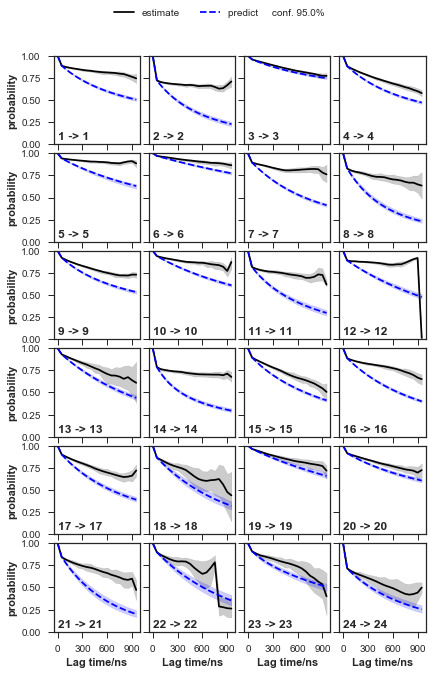

In [31]:
plt.rcParams['axes.labelweight'] = 'bold'
fig, axes = pyemma.plots.plot_cktest(cktest_none, diag=True, units='ns', dt=0.5)
axes[5,0].set_xlabel('Lag time/ns')
axes[5,1].set_xlabel('Lag time/ns')
axes[5,2].set_xlabel('Lag time/ns')
axes[5,3].set_xlabel('Lag time/ns')
axes[5,0].set_xticks([0,300,600,900])
plt.savefig('cktest_apo_diag_none.pdf')
plt.show()